### Load important packages

In [ ]:
from tqdm import tqdm
import joblib
import numpy as np
from pyxtal.symmetry import Group
import numpy as np
import sys
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import torch
import torch.nn.functional as F

from tqdm import tqdm
from sklearn.metrics import roc_curve, auc,accuracy_score
from pyxtal.symmetry import Group
from dis_gen.model import CrystalDataset, VAE
from dis_gen.loss_function import vae_loss_function
from dis_gen.generation import decode_samples

### Load model and data

In [2]:
# Load the VAE model
model_dir = 'New_Kl5_ICSD_dis_site_middle_KL_element1000_lr_5e-06_epochs_2500_batch_64_test_0.2_val_0.1'
best_model = True

if best_model:
    vae_dict = torch.load(model_dir+'/best_vae_model.pth',map_location=torch.device('cpu'))
else: # use exit model
    vae_dict = torch.load(model_dir+'/exit_vae_model.pth',map_location=torch.device('cpu'))

feature_dim = 183
wyckoff_dim = 9
crystal_dim = 236
kernel = [5,3,2]
stride = [2,3,2]
max_filter = 16
latent_dim = 256
vae_eval = VAE(feature_dim, wyckoff_dim, crystal_dim,verbose=False,kernel=kernel,stride=stride)
vae_eval.load_state_dict(vae_dict['model'])


<All keys matched successfully>

In [3]:
# Put in the path to the coorrect test dataset
x_test = torch.tensor(np.load('/home/energy/mahpe/Published_code/dis_gen_X_test.npy'), dtype=torch.float32)
y_test = torch.tensor(np.load('/home/energy/mahpe/Published_code/dis_gen_Y_test.npy'), dtype=torch.float32)
print('x_test shape:', x_test.shape)
print('y_test shape:', y_test.shape)

# Get model coefficients
coeffs = vae_dict['coeffs']
print('Coefficients:', coeffs)
# Predict the decoded output
out_test = vae_eval(x_test, y_test)
# Compute test loss
loss = vae_loss_function(out_test, x_test, y_test, coeffs,verbose=True);
for key in loss:
    print(f"{key}: {loss[key]}")

x_test shape: torch.Size([27008, 9, 183])
y_test shape: torch.Size([27008, 236])
Coefficients: {'kl': 1.0, 'element': 1000.0, 'wyckoff_letter': 1.0, 'wyckoff_multiplier': 1.0, 'frac_coords': 1.0, 'space_group': 10.0, 'lattice': 3.0, 'disordered_site': 0.1}
Original: torch.Size([27008, 9, 183])
Reconstructed: torch.Size([27008, 9, 101]) torch.Size([27008, 9, 51]) torch.Size([27008, 9, 3]) torch.Size([27008, 9, 27]) torch.Size([27008, 9, 1])
Z mean: torch.Size([27008, 256])
Z log var: torch.Size([27008, 256])
Coeffs: {'kl': 1.0, 'element': 1000.0, 'wyckoff_letter': 1.0, 'wyckoff_multiplier': 1.0, 'frac_coords': 1.0, 'space_group': 10.0, 'lattice': 3.0, 'disordered_site': 0.1}
---------------------------------
KL Loss i: torch.Size([27008, 256])
KL Loss: torch.Size([])
Element Loss i: torch.Size([9, 27008])
Element Loss: torch.Size([])
Wyckoff Loss i: torch.Size([9, 27008])
Wyckoff Loss: torch.Size([])
Wyckoff Multiplier Loss i: torch.Size([9, 27008])
Wyckoff Multiplier Loss: torch.Size([

/home/energy/mahpe/anaconda3/envs/env_sylg/lib/python3.11/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


In [ ]:
if 'Y_scaler' in vae_dict:
    scaler_Y = vae_dict['Y_scaler']
else:
    # Load the scaler if not present in the model dictionary
    print('Loading Y_scaler from file Y_scaler.gz')
    scaler_Y = joblib.load('Y_scaler.gz')


x_test_plot = x_test.cpu().detach().numpy()
y_test_plot = y_test.cpu().detach().numpy()

vae_element = out_test['decoded_element'].cpu().detach().numpy()
vae_wyckoff_multiplier = out_test['decoded_wyckoff_multiplier'].cpu().detach().numpy()
vae_frac_coords = out_test['decoded_frac_coords'].cpu().detach().numpy()
vae_wyckoff_letter = out_test['decoded_wyckoff_letter'].cpu().detach().numpy()
vae_disordered_site = out_test['decoded_disordered_site'].cpu().detach().numpy()

vae_sg = out_test['decoded_sg'].cpu().detach().numpy()
vae_lattice = out_test['decoded_lattice'].cpu().detach().numpy()

# Inverse transform the data
y_test_lattice = scaler_Y.inverse_transform(y_test_plot[:,:6])
y_test_sg = y_test_plot[:,6:]
vae_lattice = scaler_Y.inverse_transform(vae_lattice)

print('X:',x_test_plot.shape)
print('Y:',y_test_plot.shape)
print('VAE element:',vae_element.shape)
print('VAE Wyckoff Multiplier:',vae_wyckoff_multiplier.shape)
print('VAE Frac Coords:',vae_frac_coords.shape)
print('VAE Wyckoff Letter:',vae_wyckoff_letter.shape)
print('VAE SG:',vae_sg.shape)
print('VAE Lattice:',vae_lattice.shape)

Loading Y_scaler from file Y_scaler.gz
X: (27008, 9, 183)
Y: (27008, 236)
VAE element: (27008, 9, 101)
VAE Wyckoff Multiplier: (27008, 9, 51)
VAE Frac Coords: (27008, 9, 3)
VAE Wyckoff Letter: (27008, 9, 27)
VAE SG: (27008, 230)
VAE Lattice: (27008, 6)


### Lattice reconstruction loss

VAE: (27008, 3) (27008, 3) (27008,) (243072,)
Test: (27008, 3) (27008, 3) (27008,) (243072,)
---------------------------------
$a$ (MAE: 0.06)
$\alpha$ (MAE: 0.02)
$b$ (MAE: 0.06)
$\beta$ (MAE: 0.05)
$c$ (MAE: 0.10)
$\gamma$ (MAE: 0.28)
Disordered Site (Acc: 0.99800)
Spacegroup (Acc: 0.994)


(1.0, 229.0, 1.0, 229.0)

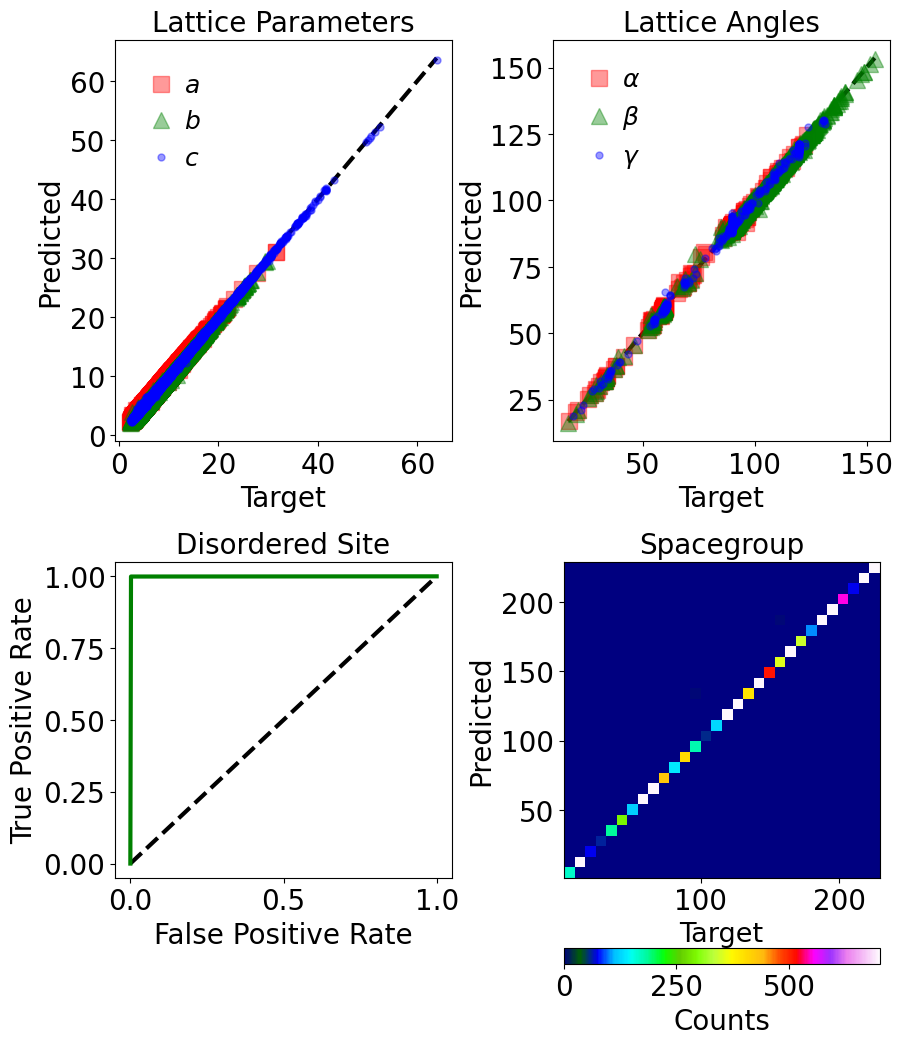

In [6]:
abc_vae = vae_lattice[:, :3]
angles_vae = vae_lattice[:, 3:]
spacegroup_vae = np.argmax(vae_sg, axis=1)
disordered_site_vae = F.sigmoid(torch.tensor(vae_disordered_site)).cpu().detach().numpy().flatten()
disordered_site_vae_index = disordered_site_vae>0.01
disordered_site_vae[~disordered_site_vae_index] = 0
disordered_site_vae_index = disordered_site_vae<0.01
disordered_site_vae[~disordered_site_vae_index] = 1
disordered_site_vae = disordered_site_vae
print('VAE:',abc_vae.shape, angles_vae.shape, spacegroup_vae.shape, disordered_site_vae.shape)

abc_test = y_test_lattice[:, :3]
angles_test = y_test_lattice[:, 3:6]
spacegroup_test = np.argmax(y_test_sg, axis=1)
disordered_site_test = x_test_plot[:,:,-31].flatten()
print('Test:',abc_test.shape, angles_test.shape, spacegroup_test.shape, disordered_site_test.shape)
print('---------------------------------')
# Plot the Crystal representation in three plots
fig, ax = plt.subplots(2, 2, figsize=(10, 12),gridspec_kw={'wspace':0.3,'hspace':0.3})
font_size = 20
handlelength = 0.2
shapes = ['s','^','.']
colors = ['r','g','b']
markersize = [12,11,10]
abc_labels = [r'$a$',r'$b$',r'$c$']
label_loc = [0.1,0.65]
alpha = 0.4
angle_labels = [r'$\alpha$',r'$\beta$',r'$\gamma$']
xlabel = 'Target'
ylabel = 'Predicted'
lw=3
vmin = 0
vmax = 700
bbox=dict(facecolor='none', edgecolor='black', boxstyle='round,pad=0.2')
cmap = 'gist_ncar'
# cmap = 'jet_r'
origin = 'lower'
aspect = 'equal'

ax[0,0].plot([np.min(abc_test),np.max(abc_test)],[np.min(abc_test),np.max(abc_test)],'k--',lw=lw)
ax[0,1].plot([np.min(angles_test),np.max(angles_test)],[np.min(angles_test),np.max(angles_test)],'k--',lw=lw)
#ax[2].plot([np.min(spacegroup_test),np.max(spacegroup_test)],[np.min(spacegroup_test),np.max(spacegroup_test)],'k--')
for i in range(3):
    mae = np.mean(np.abs(abc_test[:,i] - abc_vae[:,i]))
    ax[0,0].plot(abc_test[:,i], abc_vae[:,i], marker=shapes[i], color=colors[i], linestyle='None', label=abc_labels[i],alpha=alpha,markersize=markersize[i])
    ax[0,0].set_xlabel(xlabel, fontsize=font_size)
    ax[0,0].set_ylabel(ylabel, fontsize=font_size)
    ax[0,0].set_title('Lattice Parameters', fontsize=font_size)
    ax[0,0].tick_params(axis='both', which='major', labelsize=font_size)
    ax[0,0].tick_params(axis='both', which='minor', labelsize=font_size)
    
    ax[0,0].legend(fontsize=font_size-2,loc=label_loc,frameon=False,handlelength=handlelength)
    print(abc_labels[i]+f' (MAE: {mae:.2f})')

    mae = np.mean(np.abs(angles_test[:,i] - angles_vae[:,i]))
    ax[0,1].plot(angles_test[:,i], angles_vae[:,i], marker=shapes[i], color=colors[i], linestyle='None', label=angle_labels[i],alpha=alpha,markersize=markersize[i])
    ax[0,1].set_xlabel(xlabel, fontsize=font_size)
    ax[0,1].set_ylabel(ylabel, fontsize=font_size)
    ax[0,1].set_title('Lattice Angles', fontsize=font_size)
    ax[0,1].tick_params(axis='both', which='major', labelsize=font_size)
    ax[0,1].tick_params(axis='both', which='minor', labelsize=font_size)
    ax[0,1].legend(fontsize=font_size-2,loc=label_loc,frameon=False,handlelength=handlelength)

    print(angle_labels[i]+f' (MAE: {mae:.2f})')

# Disordered site

acc_disorder = accuracy_score(disordered_site_test,disordered_site_vae)
print(f'Disordered Site (Acc: {acc_disorder:.5f})')

fpr, tpr, _ = roc_curve(disordered_site_test, disordered_site_vae)
roc_auc = auc(fpr, tpr)
# chnage size of axis
ax[1,0]

ax[1,0].plot([0, 1], [0, 1], color='black',lw=lw, linestyle='--')
ax[1,0].plot(fpr, tpr, color='green',lw=lw, label=f'ROC curve (area = {roc_auc:.2f})')
ax[1,0].set_xlabel('False Positive Rate', fontsize=font_size)
ax[1,0].set_ylabel('True Positive Rate', fontsize=font_size)
ax[1,0].tick_params(axis='both', which='major', labelsize=font_size)
ax[1,0].tick_params(axis='both', which='minor', labelsize=font_size)
ax[1,0].set_title('Disordered Site', fontsize=font_size)
#ax[1,1].legend(fontsize=font_size-2,frameon=False)
divider = make_axes_locatable(ax[1,0])
cax = divider.new_vertical(size="5%", pad=0.7, pack_start=True)
#fig.add_axes(cax)

# Spacegroup
# Accuracy
spg_accuracy = accuracy_score(spacegroup_test, spacegroup_vae)
#spg_accuracy = np.mean(spacegroup_test == spacegroup_vae)
#mae = np.mean(np.abs(spacegroup_test - spacegroup_vae))
print(f'Spacegroup (Acc: {spg_accuracy:.3f})')

heatmap, xedges, yedges = np.histogram2d(spacegroup_test, spacegroup_vae, bins=30)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
im = ax[1,1].imshow(heatmap.T, extent=extent, origin=origin,cmap=cmap,aspect=aspect,vmin=vmin,vmax=vmax)
#ax[2].plot(spacegroup_test, spacegroup_vae, marker='.', color='r', linestyle='None')
ax[1,1].set_xlabel(xlabel, fontsize=font_size-0.5)
ax[1,1].set_ylabel(ylabel, fontsize=font_size)
ax[1,1].set_title('Spacegroup', fontsize=font_size)
ax[1,1].tick_params(axis='both', which='major', labelsize=font_size)
ax[1,1].tick_params(axis='both', which='minor', labelsize=font_size)

divider = make_axes_locatable(ax[1,1])
cax = divider.new_vertical(size="5%", pad=0.7, pack_start=True)
fig.add_axes(cax)
cbar = fig.colorbar(im, cax=cax, orientation="horizontal")
cbar.set_label('Counts', fontsize=font_size)
cbar.ax.tick_params(labelsize=font_size)
ax[1,1].axis('equal')


### Atomic reconstruction

Disordered sites: 45141
Partial occupancy (MAE): 0.06375135749305977
Wyckoff Multiplicity (Acc): 0.9961475217289171
Wyckoff Letter (Acc): 0.9946910970166785
Fractional Coordinates (MAE): 0.068356246
-------------------------------------
Ordered sites: 78298
Element (Acc): 0.9855040997215765
Wyckoff Multiplicity (Acc): 0.9977521775779713
Wyckoff Letter (Acc): 0.9970114179161664
Fractional Coordinates (MAE): 0.074869774


Text(0.5, 1.03, 'Ordered Wyckoff sites')

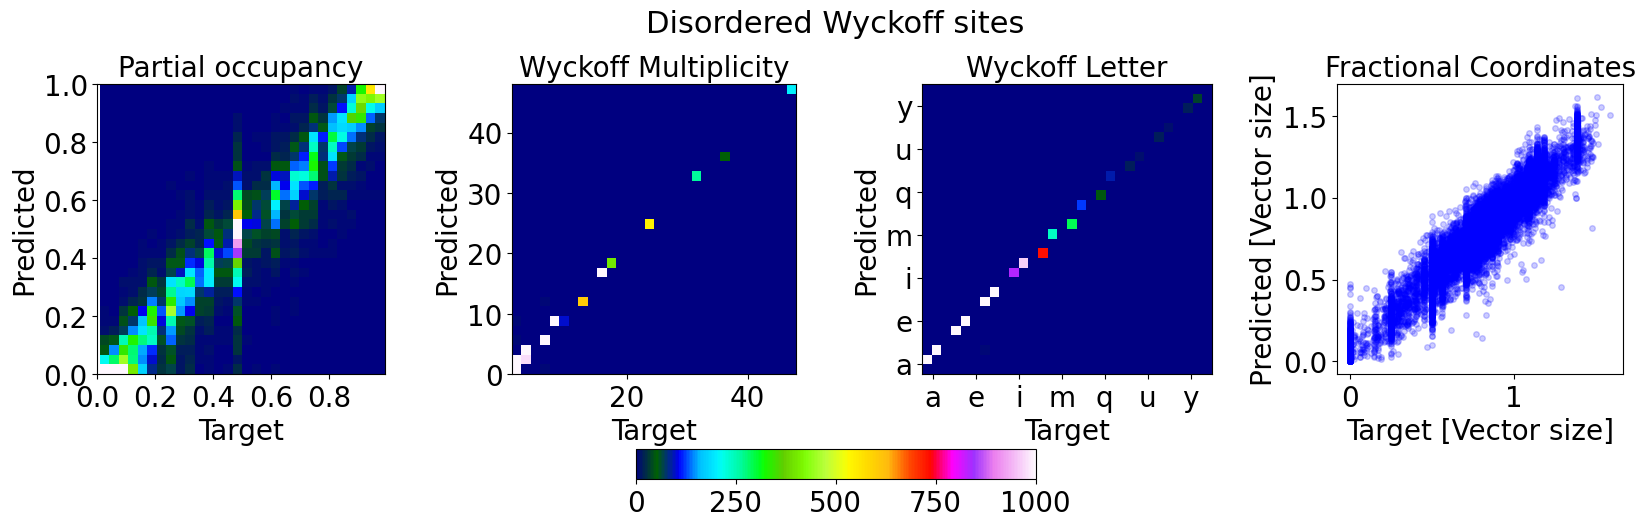

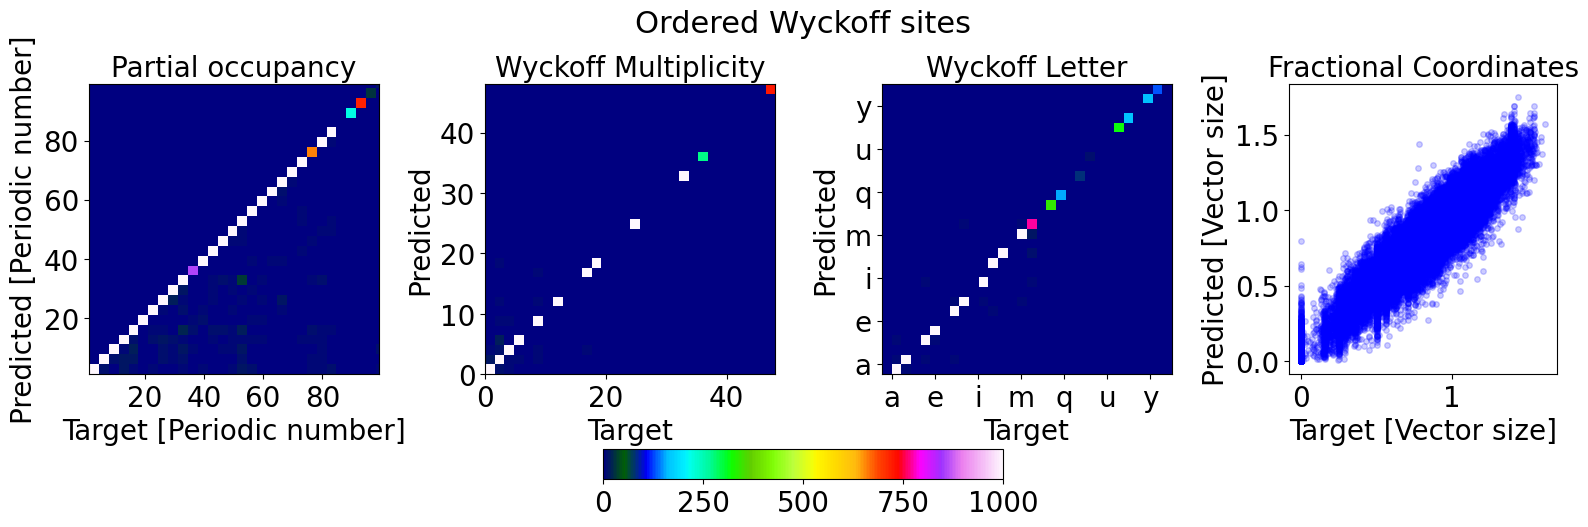

In [8]:
# Remove data points which are zero padding
element_test = x_test_plot[:,:,:101]
frac_coords_test = x_test_plot[:,:,-30:-27]
wyckoff_letter_test = x_test_plot[:,:,-27:]
wyckoff_mult_test = x_test_plot[:,:,101:-31]

element_test_occ_disorder = []
element_test_int_disorder = []
wyckoff_mult_test_plot_disorder = []
wyckoff_letter_test_plot_disorder = []
frac_coords_test_plot_disorder = []

element_test_occ_order = []
element_test_int_order = []
wyckoff_mult_test_plot_order = []
wyckoff_letter_test_plot_order = []
frac_coords_test_plot_order = []

wyckoff_mult_vae_plot_disorder = []
wyckoff_letter_vae_plot_disorder = []
frac_coords_vae_plot_disorder = []
element_vae_occ_disorder = []
element_vae_int_disorder = []


wyckoff_mult_vae_plot_order = []
wyckoff_letter_vae_plot_order = []
frac_coords_vae_plot_order = []
element_vae_occ_order = []
element_vae_int_order = []

for i in range(element_test.shape[0]):
    # Use wyckoff letter and multiplier to remove zero padding
    wyckoff_letter_vae_i = np.argmax(vae_wyckoff_letter[i],axis=1)
    wyckoff_mult_vae_i = np.argmax(vae_wyckoff_multiplier[i],axis=1)

    wyckoff_letter_test_i = np.argmax(wyckoff_letter_test[i],axis=1)
    wyckoff_mult_test_i = np.argmax(wyckoff_mult_test[i],axis=1)

    # Find the zeros in the wyckoff letter and multiplier
    index = wyckoff_letter_vae_i != 0

    # Define element occupations:
    element_vae_i = np.round(vae_element[i,index,:],2)
    element_test_i = np.round(element_test[i,index,:],2)

    # Assume that if a properbility is lower than 1% it is zero
    element_index = element_vae_i > 0.01
    element_vae_i[~element_index] = 0

    # Loop over each wyckoff site
    for site in range(element_vae_i.shape[0]):
        # Define element occupations for the site
        elem_test_list,elem_vae_list = element_test_i[site],element_vae_i[site]

        # Find the elements which are occupied
        element_int_index = np.where(elem_test_list>0)[0]
        # Sort the elements by occupation
        #element_int_vae_index= np.argsort(elem_vae_list)[::-1]

        if len(element_int_index) > 1:
            # Disorder
            n_disorder = len(element_int_index)
            element_int_test_index = np.argsort(elem_test_list)[::-1]

            # Loop over the elements
            for n in range(n_disorder):
                elem = element_int_test_index[n]
                element_test_occ_disorder.append(elem_test_list[elem])
                element_test_int_disorder.append(elem+1) # +1 to get the correct element
                
                

                if elem_vae_list[elem] == 0:
                    element_vae_int_disorder.append(0)
                    element_vae_occ_disorder.append(0)
                else:
                    element_vae_int_disorder.append(elem+1) # +1 to get the correct element
                    element_vae_occ_disorder.append(elem_vae_list[elem])
            # Find the element with the highest occupation
            

            wyckoff_mult_vae_plot_disorder.append(wyckoff_mult_vae_i[site])
            wyckoff_letter_vae_plot_disorder.append(wyckoff_letter_vae_i[site])
            frac_coords_vae_plot_disorder.append(vae_frac_coords[i,site,:])

            wyckoff_mult_test_plot_disorder.append(wyckoff_mult_test_i[site])
            wyckoff_letter_test_plot_disorder.append(wyckoff_letter_test_i[site])
            frac_coords_test_plot_disorder.append(frac_coords_test[i,site,:])
        else:
            # Ordered
            # Loop over the elements
            for elem in element_int_index:
                element_test_occ_order.append(elem_test_list[elem])
                element_test_int_order.append(elem+1)

            element_int_vae_index = np.argmax(elem_vae_list>0)
            element_vae_int_order.append(element_int_vae_index+1) # +1 to get the correct element
            element_vae_occ_order.append(elem_vae_list[element_int_vae_index])
            
            wyckoff_mult_vae_plot_order.append(wyckoff_mult_vae_i[site])
            wyckoff_letter_vae_plot_order.append(wyckoff_letter_vae_i[site])
            frac_coords_vae_plot_order.append(vae_frac_coords[i,site,:])

            wyckoff_mult_test_plot_order.append(wyckoff_mult_test_i[site])
            wyckoff_letter_test_plot_order.append(wyckoff_letter_test_i[site])
            frac_coords_test_plot_order.append(frac_coords_test[i,site,:])


# Plot VAE vs ICSD
# Disordered
fig, ax = plt.subplots(1, 4, figsize=(20, 5),gridspec_kw={'wspace':0.33})
font_size = 20
marker = '.'
color = 'b'
alpha = 0.2
marker = '.'
marker_size = 8
legend_loc = (0,-0.3)
text_loc = (0.2,-0.25)
bbox=dict(facecolor='none', edgecolor='black', boxstyle='round,pad=0.2')
xlabel = 'Target'
ylabel = 'Predicted'
cmap = 'gist_ncar'
origin = 'lower'
aspect = 'equal'
vmin = 0
vmax= 1000
Nbins = 30

handlelength = 0.2
shapes = ['s','^','.']
colors = ['r','g','b']
marker_sizes = [9,8,7]
label_name = [r'$x$',r'$y$',r'$z$']
label_loc = [0.1,0.65]

print('Disordered sites:',len(element_test_occ_disorder))
# Element Occupation
element_test_plot = np.array(element_test_occ_disorder)
element_vae_plot = np.array(element_vae_occ_disorder)

mae_element = np.mean(np.abs(element_test_plot - element_vae_plot))
# heatmap
heatmap, xedges, yedges = np.histogram2d(element_test_plot, element_vae_plot, bins=Nbins)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
im = ax[0].imshow(heatmap.T, extent=extent, origin=origin,cmap=cmap,aspect=aspect,vmin=vmin,vmax=vmax)
ax[0].set_xlabel(xlabel, fontsize=font_size)
ax[0].set_ylabel(ylabel, fontsize=font_size)
ax[0].set_title('Partial occupancy', fontsize=font_size)
ax[0].tick_params(axis='both', which='major', labelsize=font_size)
ax[0].tick_params(axis='both', which='minor', labelsize=font_size)
ax[0].set_xticks(np.arange(0,1, step=0.2,))
print('Partial occupancy (MAE):',mae_element)

# Wyckoff Multiplicity +1 to get the correct number
wyckoff_mult_test_plot = np.array(wyckoff_mult_test_plot_disorder)
wyckoff_mult_vae_plot = np.array(wyckoff_mult_vae_plot_disorder)
acc_wyckoff_mult = accuracy_score(wyckoff_mult_test_plot, wyckoff_mult_vae_plot) # same as taking the mean of the wyckoff sites and then the mean of the structures


heatmap, xedges, yedges = np.histogram2d(wyckoff_mult_test_plot, wyckoff_mult_vae_plot, bins=Nbins)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
im = ax[1].imshow(heatmap.T, extent=extent, origin=origin,cmap=cmap,aspect=aspect,vmin=vmin,vmax=vmax)
ax[1].set_xlabel(xlabel, fontsize=font_size)
ax[1].set_ylabel(ylabel, fontsize=font_size)
ax[1].set_title('Wyckoff Multiplicity', fontsize=font_size)
ax[1].tick_params(axis='both', which='major', labelsize=font_size)
ax[1].tick_params(axis='both', which='minor', labelsize=font_size)

print('Wyckoff Multiplicity (Acc):',acc_wyckoff_mult)

# Wyckoff Letter -1 to get the correct letter
wyckoff_letter_test_plot = np.array(wyckoff_letter_test_plot_disorder)
wyckoff_letter_vae_plot = np.array(wyckoff_letter_vae_plot_disorder)
acc_wyckoff_letter = accuracy_score(wyckoff_letter_test_plot, wyckoff_letter_vae_plot)


heatmap, xedges, yedges = np.histogram2d(wyckoff_letter_test_plot, wyckoff_letter_vae_plot, bins=Nbins)
extent = [0, 27, 0, 27]
im = ax[2].imshow(heatmap.T, extent=extent, origin=origin,cmap=cmap,aspect=aspect,vmin=vmin,vmax=vmax)
ax[2].set_xlabel(f'{xlabel}', fontsize=font_size)
ax[2].set_ylabel(f'{ylabel}', fontsize=font_size)
ax[2].set_title('Wyckoff Letter', fontsize=font_size)

wyckoff_label = {i:chr(i+97) for i in range(26)}
ax[2].set_xticks(np.arange(1,26,4))
ax[2].set_xticklabels([wyckoff_label[i-1] for i in ax[2].get_xticks()])
ax[2].set_yticks(np.arange(1,26,4))
ax[2].set_yticklabels([wyckoff_label[i-1] for i in ax[2].get_yticks()])
ax[2].tick_params(axis='both', which='major', labelsize=font_size)
ax[2].tick_params(axis='both', which='minor', labelsize=font_size)
print('Wyckoff Letter (Acc):',acc_wyckoff_letter)

# Fractional Coordinates
frac_coords_test_plot = np.sqrt(np.sum(np.square(frac_coords_test_plot_disorder),axis=1))
frac_coords_vae_plot = np.sqrt(np.sum(np.square(frac_coords_vae_plot_disorder),axis=1))
frac_coords_test_plot = frac_coords_test_plot.flatten()
frac_coords_vae_plot = frac_coords_vae_plot.flatten()
mae_frac_coords = np.mean(np.abs(frac_coords_test_plot - frac_coords_vae_plot))
print('Fractional Coordinates (MAE):',mae_frac_coords)

ax[3].plot(frac_coords_test_plot, frac_coords_vae_plot, marker=marker, color=color, 
            linestyle='None',label=f'MAE: {mae:.2f}',alpha=alpha,markersize=marker_size)
ax[3].set_xlabel(f'{xlabel} [Vector size]', fontsize=font_size)
ax[3].set_ylabel(f'{ylabel} [Vector size]', fontsize=font_size)
ax[3].set_title('Fractional Coordinates', fontsize=font_size)
ax[3].tick_params(axis='both', which='major', labelsize=font_size)
ax[3].tick_params(axis='both', which='minor', labelsize=font_size)
ax[3].set(adjustable='box', aspect='equal')

fig.subplots_adjust(bottom=0.3)
cbar_ax = fig.add_axes([0.4, 0.09, 0.2, 0.06]) # x, y, width, height
cbar_ax.set_xlabel('Counts', fontsize=font_size)
cbar_ax.tick_params(axis='both', which='major', labelsize=font_size)
cbar_ax.tick_params(axis='both', which='minor', labelsize=font_size)
fig.colorbar(im, cax=cbar_ax, orientation='horizontal')

# Set subplot title
fig.suptitle('Disordered Wyckoff sites', fontsize=font_size+2, y=1.03)

print('-------------------------------------')
print('Ordered sites:',len(element_test_int_order))
# Ordered
fig, ax = plt.subplots(1, 4, figsize=(20, 5),gridspec_kw={'wspace':0.1})
vmin = 0
vmax= 1000
# Element INT
acc_element = accuracy_score(element_test_int_order, element_vae_int_order)
heatmap, xedges, yedges = np.histogram2d(element_test_int_order, element_vae_int_order, bins=Nbins)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
im = ax[0].imshow(heatmap.T, extent=extent, origin=origin,cmap=cmap,aspect=aspect,vmin=vmin,vmax=vmax)
ax[0].set_xlabel(f'{xlabel} [Periodic number]', fontsize=font_size)
ax[0].set_ylabel(f'{ylabel} [Periodic number]', fontsize=font_size)
ax[0].set_title('Partial occupancy', fontsize=font_size)
ax[0].tick_params(axis='both', which='major', labelsize=font_size)
ax[0].tick_params(axis='both', which='minor', labelsize=font_size)
ax[0].set_ylim(1,99)
ax[0].set_xlim(1,99)
ax[0].set_xticks(np.array([20,40,60,80]))
print('Element (Acc):',acc_element)

# Wyckoff Multiplicity +1 to get the correct number
wyckoff_mult_test_plot = np.array(wyckoff_mult_test_plot_order)
wyckoff_mult_vae_plot = np.array(wyckoff_mult_vae_plot_order)
acc_wyckoff_mult = accuracy_score(wyckoff_mult_test_plot, wyckoff_mult_vae_plot) # same as taking the mean of the wyckoff sites and then the mean of the structures
heatmap, xedges, yedges = np.histogram2d(wyckoff_mult_test_plot, wyckoff_mult_vae_plot, bins=Nbins)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
im = ax[1].imshow(heatmap.T, extent=extent, origin=origin,cmap=cmap,aspect=aspect,vmin=vmin,vmax=vmax)
ax[1].set_xlabel(xlabel, fontsize=font_size)
ax[1].set_ylabel(ylabel, fontsize=font_size)
ax[1].set_title('Wyckoff Multiplicity', fontsize=font_size)
ax[1].tick_params(axis='both', which='major', labelsize=font_size)
ax[1].tick_params(axis='both', which='minor', labelsize=font_size)
print('Wyckoff Multiplicity (Acc):',acc_wyckoff_mult)

# Wyckoff Letter -1 to get the correct letter
wyckoff_letter_test_plot = np.array(wyckoff_letter_test_plot_order)
wyckoff_letter_vae_plot = np.array(wyckoff_letter_vae_plot_order)

acc_wyckoff_letter = accuracy_score(wyckoff_letter_test_plot, wyckoff_letter_vae_plot)
heatmap, xedges, yedges = np.histogram2d(wyckoff_letter_test_plot, wyckoff_letter_vae_plot, bins=Nbins)
extent = [0, 27, 0, 27]
im = ax[2].imshow(heatmap.T, extent=extent, origin=origin,cmap=cmap,aspect=aspect,vmin=vmin,vmax=vmax)

ax[2].set_xlabel(f'{xlabel}', fontsize=font_size)
ax[2].set_ylabel(f'{ylabel}', fontsize=font_size)
ax[2].set_title('Wyckoff Letter', fontsize=font_size)
ax[2].tick_params(axis='both', which='major', labelsize=font_size)
ax[2].tick_params(axis='both', which='minor', labelsize=font_size)

wyckoff_label = {i:chr(i+97) for i in range(26)}

ax[2].set_xticks(np.arange(1,26,4))
ax[2].set_xticklabels([wyckoff_label[i-1] for i in ax[2].get_xticks()])
ax[2].set_yticks(np.arange(1,26,4))
ax[2].set_yticklabels([wyckoff_label[i-1] for i in ax[2].get_yticks()])

print('Wyckoff Letter (Acc):',acc_wyckoff_letter)

# Fractional Coordinates
frac_coords_test_plot = np.sqrt(np.sum(np.square(frac_coords_test_plot_order),axis=1))
frac_coords_vae_plot = np.sqrt(np.sum(np.square(frac_coords_vae_plot_order),axis=1))
frac_coords_test_plot = frac_coords_test_plot.flatten()
frac_coords_vae_plot = frac_coords_vae_plot.flatten()
mae_frac_coords = np.mean(np.abs(frac_coords_test_plot - frac_coords_vae_plot))
print('Fractional Coordinates (MAE):',mae_frac_coords)

heatmap, xedges, yedges = np.histogram2d(frac_coords_test_plot, frac_coords_vae_plot, bins=Nbins)
extent = [yedges[0], yedges[-1], yedges[0], yedges[-1]]
ax[3].plot(frac_coords_test_plot, frac_coords_vae_plot, marker=marker, color=color, 
            linestyle='None',label=f'MAE: {mae:.2f}',alpha=alpha,markersize=marker_size)
ax[3].set_xlabel(f'{xlabel} [Vector size]', fontsize=font_size)
ax[3].set_ylabel(f'{ylabel} [Vector size]', fontsize=font_size)
ax[3].set_title('Fractional Coordinates', fontsize=font_size)
ax[3].tick_params(axis='both', which='major', labelsize=font_size)
ax[3].tick_params(axis='both', which='minor', labelsize=font_size)
ax[3].set(adjustable='box', aspect='equal')

fig.subplots_adjust(bottom=0.3)
cbar_ax = fig.add_axes([0.4, 0.09, 0.2, 0.06]) # x, y, width, height
cbar_ax.tick_params(axis='both', which='major', labelsize=font_size)
cbar_ax.tick_params(axis='both', which='minor', labelsize=font_size)
cbar_ax.set_xlabel('Counts', fontsize=font_size)

fig.colorbar(im, cax=cbar_ax, orientation='horizontal')

fig.suptitle('Ordered Wyckoff sites', fontsize=font_size+2,y=1.03)

In [10]:
vae_wyckoff_mult_plot = []
wyckoff_mult_from_letter = []

for i in tqdm(range(element_test.shape[0])):
    # Use wyckoff letter and multiplier to remove zero padding
    wyckoff_letter_vae_i = np.argmax(vae_wyckoff_letter[i],axis=1)
    wyckoff_mult_vae_i = np.argmax(vae_wyckoff_multiplier[i],axis=1)
    spg_i = int(np.argmax(y_test[i,6:]) ) +1

    # Find the zeros in the wyckoff letter and multiplier
    index = wyckoff_letter_vae_i != 0

    # Define wyckoff_letter and wyckoff multiplier
    wyckoff_letter_vae_i_str = np.array([chr(ord('a') + l-1) for l in wyckoff_letter_vae_i[index]]) # Convert to letter from number 
    wyckoff_mult_vae_i_reduced = wyckoff_mult_vae_i[index] 
    
    # Loop over the wyckoff sites and get the multiplicity from the letter
    for vae_mult, letter in zip(wyckoff_mult_vae_i_reduced,wyckoff_letter_vae_i_str):
        try:
            mult_i = Group(spg_i).get_wp_by_letter(letter).multiplicity
        except IndexError:
            mult_i = 0
        wyckoff_mult_from_letter.append(mult_i)
        vae_wyckoff_mult_plot.append(vae_mult)



100%|██████████| 27008/27008 [15:18<00:00, 29.39it/s]


0.9957422451623269


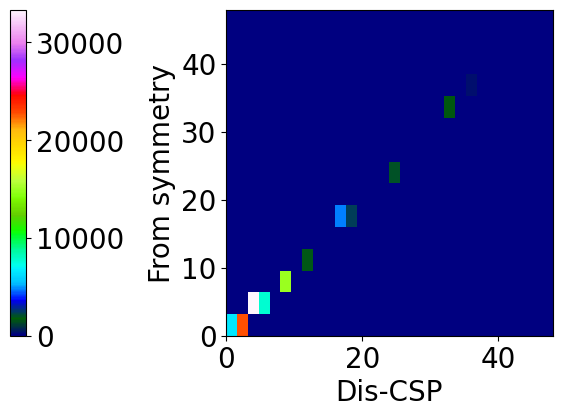

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
font_size = 20
marker = '.'
color = 'b'
alpha = 0.5
markersize= 22
acc_mult = accuracy_score(wyckoff_mult_from_letter, vae_wyckoff_mult_plot)
print(acc_mult)
heatmap, xedges, yedges = np.histogram2d(vae_wyckoff_mult_plot, wyckoff_mult_from_letter, bins=Nbins)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
im = ax.imshow(heatmap.T, extent=extent, origin=origin,cmap=cmap,aspect=aspect)

ax.set_xlabel('Dis-CSP', fontsize=font_size)
ax.set_ylabel('From symmetry', fontsize=font_size)
#ax.set_title('Wyckoff Multiplicity', fontsize=font_size)
ax.tick_params(axis='both', which='major', labelsize=font_size)
ax.tick_params(axis='both', which='minor', labelsize=font_size)
#ax.legend(fontsize=font_size,loc=(-0,-0.4))
ax.set_xlim(0,48)
ax.set_ylim(0,48)

from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(ax)
cax = divider.new_horizontal(size="5%", pad=2, pack_start=True)
fig.add_axes(cax)
cbar = fig.colorbar(im, cax=cax, orientation="vertical")
#cbar.set_label('Counts', fontsize=font_size)
cbar.ax.tick_params(labelsize=font_size)